<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Корреляционный-анализ" data-toc-modified-id="Корреляционный-анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Корреляционный анализ</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и 
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, 
которые готовы совершить покупку в ближайшее время. 

Цель: Предсказать вероятность покупки в течение 90 дней.

Предоставлены три файла с данными.

## Предобработка данных

Загрузим необходимые ресурсы и объявим константы

In [1]:
!pip install phik 
!pip freeze > requirements.txt

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
import numpy as np
import phik
import warnings
warnings.filterwarnings("ignore")

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


RANDOM_STATE = 42
TEST_SIZE = 0.25

Загрузим датафреймы

In [2]:
purchases = pd.read_csv('apparel-purchases.csv')
purchases.name = 'Данные о покупках клиентов'

messages = pd.read_csv('apparel-messages.csv')
messages.name = 'Данные о рассылках клиентам'

target = pd.read_csv('apparel-target_binary.csv')
target.name = 'Данные о целевом признаке'


Определим функцию для получения первичной информации о датасетах

In [3]:
def data_look(data):
    print(f'                  Общая информация о датафрейме ____ {data.name}\n')
    display(data.info())
    display(data.head())
    print('                   Количество пропусков по столбцам')
    display(data.isna().sum())
    print(f'                  Количество явных дубликатов {data.duplicated().sum()}, в процентном соотношении {data.duplicated().sum() / data.shape[0] * 100:.2f}%')
    print('\n                  Количество уникальных значений признаков')
    display(data.nunique())
    

In [4]:
data_look(purchases)

                  Общая информация о датафрейме ____ Данные о покупках клиентов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


                   Количество пропусков по столбцам


client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

                  Количество явных дубликатов 73020, в процентном соотношении 36.11%

                  Количество уникальных значений признаков


client_id       49849
quantity           16
price            3642
category_ids      933
date              642
message_id      50204
dtype: int64

Пропусков нет, явных дубликатов 36 процентов, однако нет данных о точном времени, пока оставим.

In [5]:
data_look(messages)

                  Общая информация о датафрейме ____ Данные о рассылках клиентам

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


                   Количество пропусков по столбцам


bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

                  Количество явных дубликатов 48610, в процентном соотношении 0.38%

                  Количество уникальных значений признаков


bulk_campaign_id       2709
client_id             53329
message_id          9061667
event                    11
channel                   2
date                    638
created_at          4103539
dtype: int64

Пропусков нет, явных дубликатов 0.38 процентов, однако есть поле с временем создания, можно удалить явные дубликаты.

In [6]:
messages.drop_duplicates(inplace=True)

In [7]:
data_look(target)

                  Общая информация о датафрейме ____ Данные о целевом признаке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


                   Количество пропусков по столбцам


client_id    0
target       0
dtype: int64

                  Количество явных дубликатов 0, в процентном соотношении 0.00%

                  Количество уникальных значений признаков


client_id    49849
target           2
dtype: int64

Пропусков нет, явных дубликатов нет. Посмотрим распределение целевого признака.

In [8]:
target.target.value_counts()

target
0    48888
1      961
Name: count, dtype: int64

Выявлен явный дисбаланс целевого признака, будем учитывать это при обучении моделей.

Перейдем к анализу распределения полей client_id. Количество уникальных значений в датасете purchases и target совпадает и равняется 49849. Проверим совпадают ли их значения.

In [9]:
purchases[~purchases['client_id'].isin(target['client_id'])]

,client_id,quantity,price,category_ids,date,message_id


Значения совпадают, можно после некоторой группировки объединять датасеты по полю client_id.

В датасете messages 53329 уникальных значения поля client_id. Проверим их совпадение и выведем число отличных client_id.

In [10]:
messages[~messages['client_id'].isin(target['client_id'])]['client_id'].nunique()

11347

В датасете messages 11347 значения поля client_id, которых нет в датасетах purchases и target. Сравним значения полей message_id в датасетах purchases и messages.

In [11]:
purchases[~purchases['message_id'].isin(messages['message_id'])]

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202197,1515915626010221592,1,1499.0,"['4', '28', '260', '1194']",2024-02-16,1515915626010221592-14664-65cf1622434a9
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


У 856 записей нет значения message_id в датасете purchases. Определим количество уникальных клиентов.

In [12]:
purchases[~purchases['message_id'].isin(messages['message_id'])]['client_id'].nunique()

401

401 клиент не имеет записей о данных сообщений.

Просто склеивать датасеты по полям client_id или message_id не представляется возможным.

In [13]:
messages = messages[messages['client_id'].isin(target['client_id'])]

In [14]:
messages.shape[0]

10913197

In [15]:
messages.event.value_counts()

event
send           7898997
open           2485299
click           443970
purchase         55704
hard_bounce      16366
soft_bounce       8915
unsubscribe       2614
hbq_spam           760
complain           495
subscribe           76
close                1
Name: count, dtype: int64

In [16]:
messages.channel.value_counts()

channel
mobile_push    6088089
email          4825108
Name: count, dtype: int64

Изучим даные датасета purchases

In [17]:
purchases.quantity.value_counts()

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

В основном записи по одному товару, значит дубликаты оставляем, так как они имеют смысл.

In [18]:
purchases.price.value_counts()

price
999.0     10233
1499.0     7520
1999.0     7150
699.0      6044
599.0      5612
          ...  
2591.0        1
2084.0        1
2476.0        1
2793.0        1
2789.0        1
Name: count, Length: 3642, dtype: int64

In [19]:
purchases.price.describe()

count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64

In [20]:
purchases['date'] = pd.to_datetime(purchases['date'])

In [21]:
str(purchases['date'].dt.date.min())

'2022-05-16'

In [22]:
str(purchases['date'].dt.date.max())

'2024-02-16'

In [23]:
purchases.category_ids.value_counts()

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '5836', '839']           1
['5562', '5632', '5552', '1089']       1
['4', '27', '278', '471']              1
['5562', '5697', '5651', '1153']       1
['5562', '5597', '5696', '5529']       1
Name: count, Length: 933, dtype: int64

In [24]:
set(purchases.category_ids.unique())

{"['1', '22', '50', '685']",
 "['1', '8', '280', '710']",
 "['2', '17', '107', '453']",
 "['2', '17', '137', '469']",
 "['2', '17', '171', '475']",
 "['2', '17', '173', '1598']",
 "['2', '17', '173', '1845']",
 "['2', '17', '173', '459']",
 "['2', '17', '180', '465']",
 "['2', '17', '1826', '1818']",
 "['2', '17', '188', '525']",
 "['2', '17', '198', '497']",
 "['2', '17', '232', '463']",
 "['2', '17', '279', '5807']",
 "['2', '17', '286', '455']",
 "['2', '17', '293', '5819']",
 "['2', '17', '330', '387', '467']",
 "['2', '17', '83', '519']",
 "['2', '17', '83', '5810']",
 "['2', '18', '123', '451']",
 "['2', '18', '155', '1325']",
 "['2', '18', '155', '439']",
 "['2', '18', '212', '658']",
 "['2', '18', '212', '659']",
 "['2', '18', '212', '726']",
 "['2', '18', '217', '662']",
 "['2', '18', '217', '663']",
 "['2', '18', '243', '440']",
 "['2', '18', '248', '449']",
 "['2', '18', '248', '677']",
 "['2', '18', '258', '1195']",
 "['2', '18', '258', '1561']",
 "['2', '18', '258', '1562'

In [25]:
purchases[purchases.category_ids=='[]']

,client_id,quantity,price,category_ids,date,message_id
22153,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
22154,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
49215,1515915625474537721,1,7.0,[],2022-11-12,1515915625474537721-7803-636dfed5eb8b6
53223,1515915625720375281,1,5.0,[],2022-11-13,1515915625720375281-7818-636f6ec29a382
59056,1515915625867975448,1,7.0,[],2022-11-16,1515915625766044118-7879-63748749d81b5
...,...,...,...,...,...,...
201990,1515915625641742458,1,7.0,[],2024-02-16,1515915625766077627-14668-65cf5246bd490
202068,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c
202069,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c
202144,1515915626007712189,1,12.0,[],2024-02-16,1515915626007712189-14648-65cdb6d1c0c2a


In [26]:
purchases[purchases.category_ids=='[None]']

,client_id,quantity,price,category_ids,date,message_id
14848,1515915625649908756,1,2499.0,[None],2022-06-17,1515915625649908756-4981-62ac2dbf52fad
32281,1515915625578652401,1,8.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f
32282,1515915625578652401,1,8.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f
32283,1515915625578652401,1,1.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f
32284,1515915625578652401,1,1.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f
...,...,...,...,...,...,...
61644,1515915625498389673,1,7.0,[None],2022-11-27,1515915625498389673-8033-637dbe2f79e78
61835,1515915625642965095,1,7.0,[None],2022-11-27,1515915625642965095-8169-6381ebba96708
61836,1515915625642965095,1,7.0,[None],2022-11-27,1515915625642965095-8169-6381ebba96708
61853,1515915625689243228,1,7.0,[None],2022-11-27,1515915625689243228-8169-6381ebbc96437


Выявлено 5579 записей с пустыми списками категорий и 1264 записи с категорией None. Приведем их к значению 0.

In [27]:
purchases.category_ids = np.where(purchases.category_ids=='[]', '0', purchases.category_ids)

In [28]:
purchases.category_ids = np.where(purchases.category_ids=='[None]', '0', purchases.category_ids)

Создадим новый признак - основная категория. Для его создания заменим

In [29]:
purchases['category_main'] = purchases.category_ids.str.extract('(\d+)')

In [30]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,category_main
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4


In [31]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      202208 non-null  int64         
 1   quantity       202208 non-null  int64         
 2   price          202208 non-null  float64       
 3   category_ids   202208 non-null  object        
 4   date           202208 non-null  datetime64[ns]
 5   message_id     202208 non-null  object        
 6   category_main  202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 10.8+ MB


In [32]:
purchases['total_price'] = purchases['quantity'] * purchases['price']

In [33]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,category_main,total_price
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,1999.0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,2499.0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4,6499.0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4,4999.0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4,4999.0


In [34]:
purchases.category_main.value_counts()

category_main
4       112578
5562     46511
2        27429
6060      7559
0         6843
5963      1272
3           11
1            3
5            2
Name: count, dtype: int64

In [35]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      202208 non-null  int64         
 1   quantity       202208 non-null  int64         
 2   price          202208 non-null  float64       
 3   category_ids   202208 non-null  object        
 4   date           202208 non-null  datetime64[ns]
 5   message_id     202208 non-null  object        
 6   category_main  202208 non-null  object        
 7   total_price    202208 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 12.3+ MB


In [36]:
purch_pivot = pd.pivot_table(purchases, index='client_id', aggfunc = {'quantity': 'sum', 'total_price' : 'sum', 'date' : ['max', pd.Series.nunique], 'message_id' : pd.Series.nunique, 'category_main' : lambda x:x.value_counts().index[0]})

In [37]:
purch_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   (category_main, <lambda>)  49849 non-null  object        
 1   (date, max)                49849 non-null  datetime64[ns]
 2   (date, nunique)            49849 non-null  int64         
 3   (message_id, nunique)      49849 non-null  int64         
 4   (quantity, sum)            49849 non-null  int64         
 5   (total_price, sum)         49849 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 2.7+ MB


In [38]:
purch_pivot.head()

category_main       date         message_id quantity  \
                         <lambda>        max nunique    nunique      sum   
client_id                                                                  
1515915625468060902             4 2022-05-27       1          1        7   
1515915625468061003             4 2023-01-04       1          1        7   
1515915625468061099             4 2022-05-17       1          1        1   
1515915625468061100             4 2024-02-10       1          1        2   
1515915625468061170             4 2023-06-17       3          3       19   

                    total_price  
                            sum  
client_id                        
1515915625468060902      6993.0  
1515915625468061003     16235.0  
1515915625468061099       299.0  
1515915625468061100      2098.0  
1515915625468061170     33601.0

In [39]:
purch_pivot.columns = ['main_category', 'last_order', 'date_count', 'message_total', 'total_quantity', 'total_price']

In [40]:
purch_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   main_category   49849 non-null  object        
 1   last_order      49849 non-null  datetime64[ns]
 2   date_count      49849 non-null  int64         
 3   message_total   49849 non-null  int64         
 4   total_quantity  49849 non-null  int64         
 5   total_price     49849 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 2.7+ MB


In [41]:
purch_pivot = purch_pivot.reset_index().rename(columns={'index':'client_id'})

In [42]:
purch_pivot.head()

,client_id,main_category,last_order,date_count,message_total,total_quantity,total_price
0,1515915625468060902,4,2022-05-27,1,1,7,6993.0
1,1515915625468061003,4,2023-01-04,1,1,7,16235.0
2,1515915625468061099,4,2022-05-17,1,1,1,299.0
3,1515915625468061100,4,2024-02-10,1,1,2,2098.0
4,1515915625468061170,4,2023-06-17,3,3,19,33601.0


In [43]:
purch_pivot.main_category.value_counts()

main_category
4       30034
5562     9644
2        7723
6060     1134
0        1010
5963      304
Name: count, dtype: int64

Создадим признак число дней с последнего заказа

In [44]:
last_date = pd.to_datetime(purchases['date'].dt.date.max())

In [45]:
last_date

Timestamp('2024-02-16 00:00:00')

In [46]:
purch_pivot['last_order']

0       2022-05-27
1       2023-01-04
2       2022-05-17
3       2024-02-10
4       2023-06-17
           ...    
49844   2024-02-16
49845   2024-02-14
49846   2024-02-16
49847   2024-02-16
49848   2024-02-16
Name: last_order, Length: 49849, dtype: datetime64[ns]

In [47]:
purch_pivot['days_to_last'] = last_date - purch_pivot['last_order']
purch_pivot['days_to_last'] = purch_pivot['days_to_last'].dt.days
purch_pivot.drop('last_order', axis=1, inplace=True)

In [48]:
purch_pivot.head()

,client_id,main_category,date_count,message_total,total_quantity,total_price,days_to_last
0,1515915625468060902,4,1,1,7,6993.0,630
1,1515915625468061003,4,1,1,7,16235.0,408
2,1515915625468061099,4,1,1,1,299.0,640
3,1515915625468061100,4,1,1,2,2098.0,6
4,1515915625468061170,4,3,3,19,33601.0,244


In [49]:
purch_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       49849 non-null  int64  
 1   main_category   49849 non-null  object 
 2   date_count      49849 non-null  int64  
 3   message_total   49849 non-null  int64  
 4   total_quantity  49849 non-null  int64  
 5   total_price     49849 non-null  float64
 6   days_to_last    49849 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.7+ MB


Объединим датасеты purch_pivot и target

In [50]:
purch_pivot = purch_pivot.merge(target, on = 'client_id')

In [51]:
purch_pivot.head()

,client_id,main_category,date_count,message_total,total_quantity,total_price,days_to_last,target
0,1515915625468060902,4,1,1,7,6993.0,630,0
1,1515915625468061003,4,1,1,7,16235.0,408,1
2,1515915625468061099,4,1,1,1,299.0,640,0
3,1515915625468061100,4,1,1,2,2098.0,6,0
4,1515915625468061170,4,3,3,19,33601.0,244,0


## Корреляционный анализ

Проведем корреляционный анализ

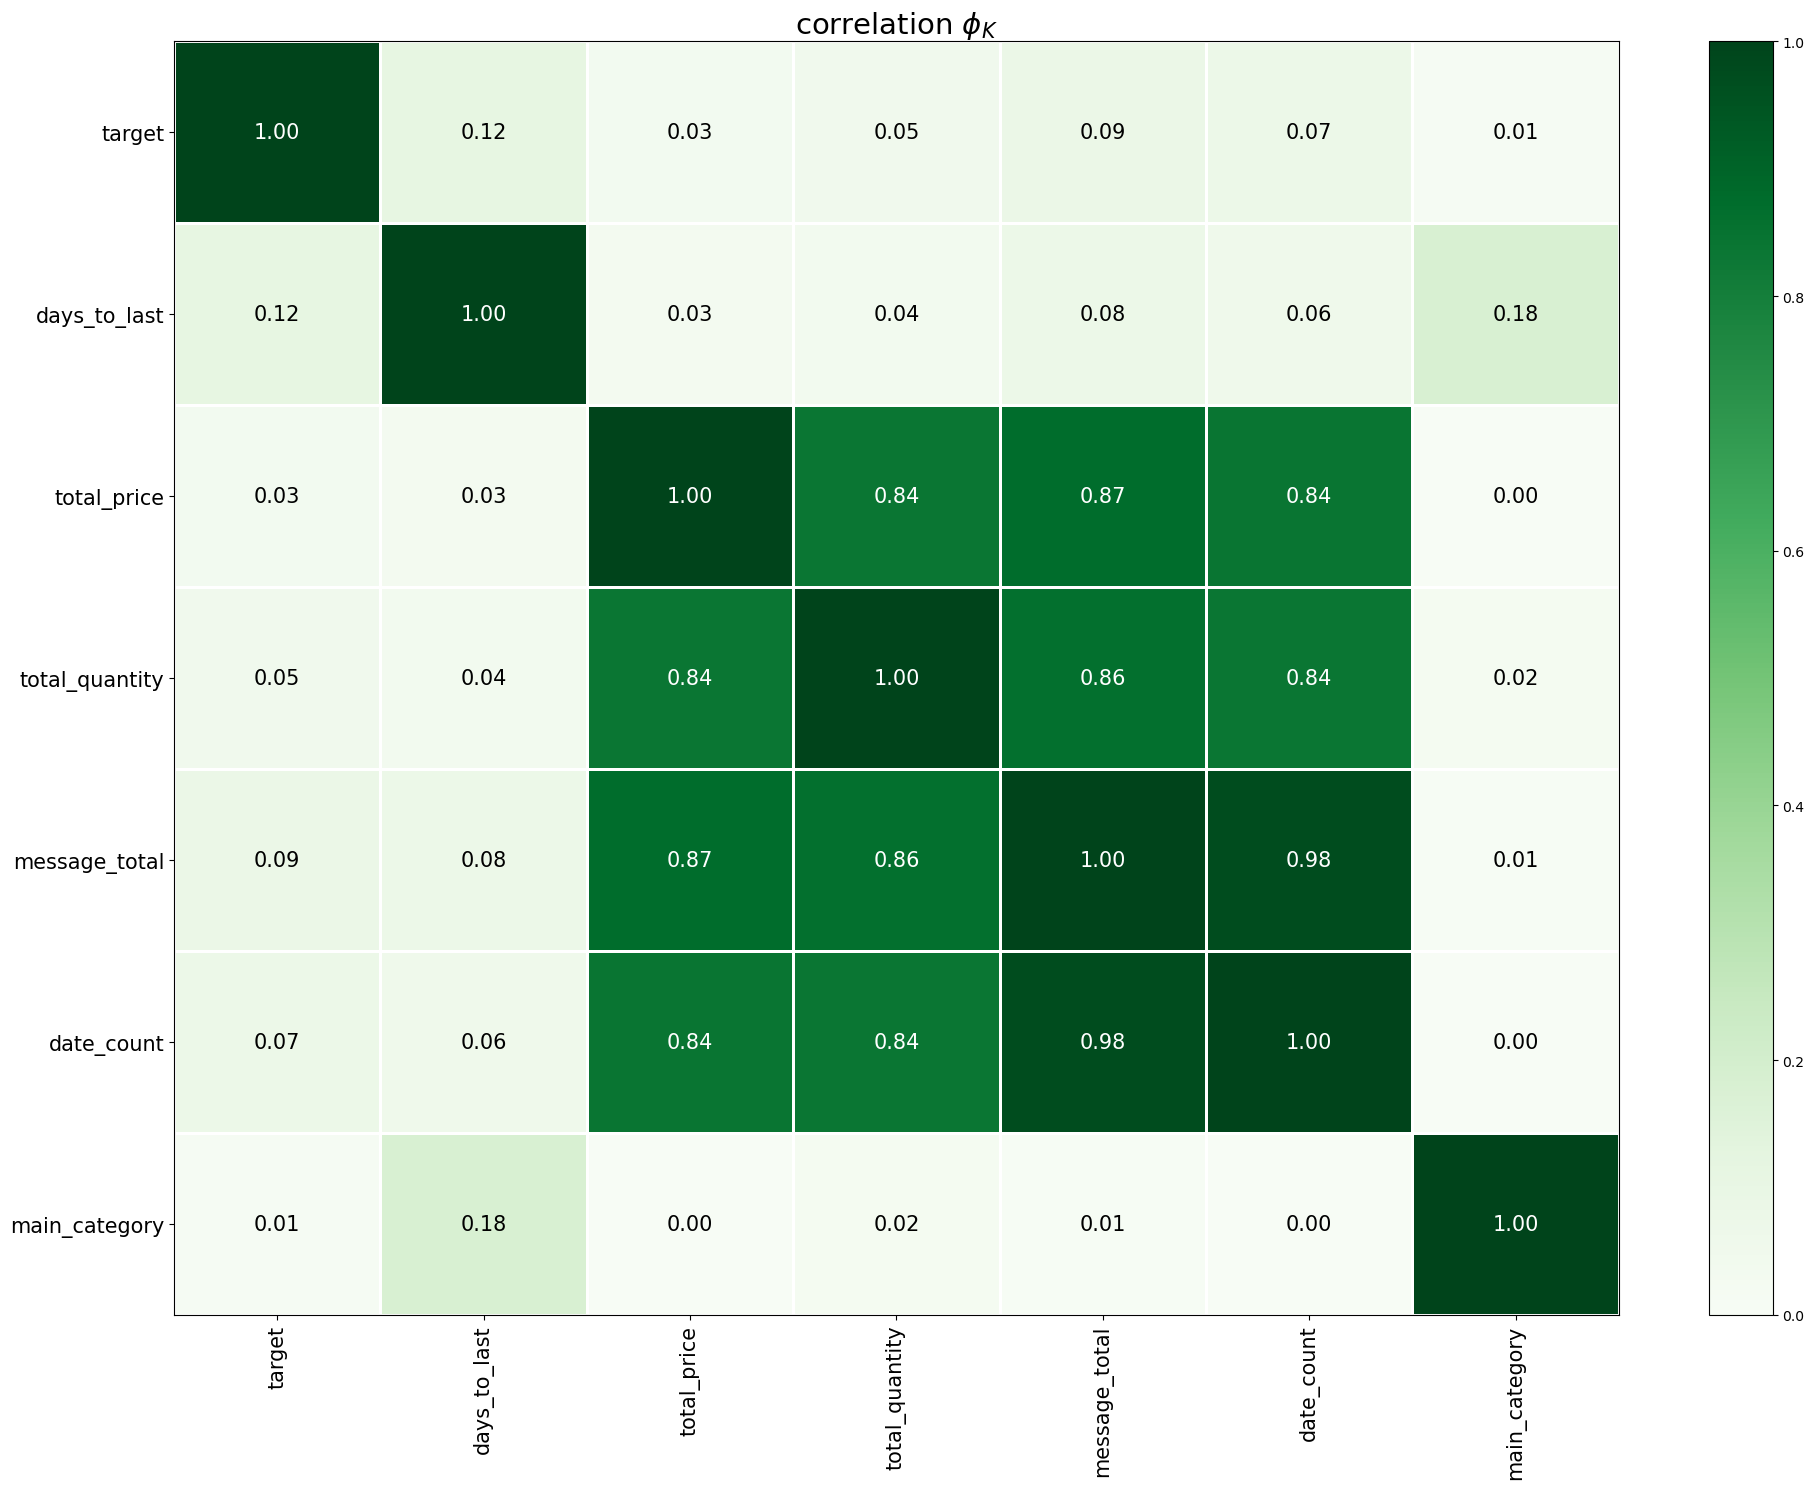

In [52]:
interval_cols =purch_pivot.select_dtypes(include='number').columns.tolist()[1:]
phik_overview = phik_matrix(purch_pivot.drop('client_id', axis=1), interval_cols=interval_cols) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Выявлена высокая степень коллинеарности между признаками количество дат покупок и общее число сообщений.

In [53]:
%xdel messages

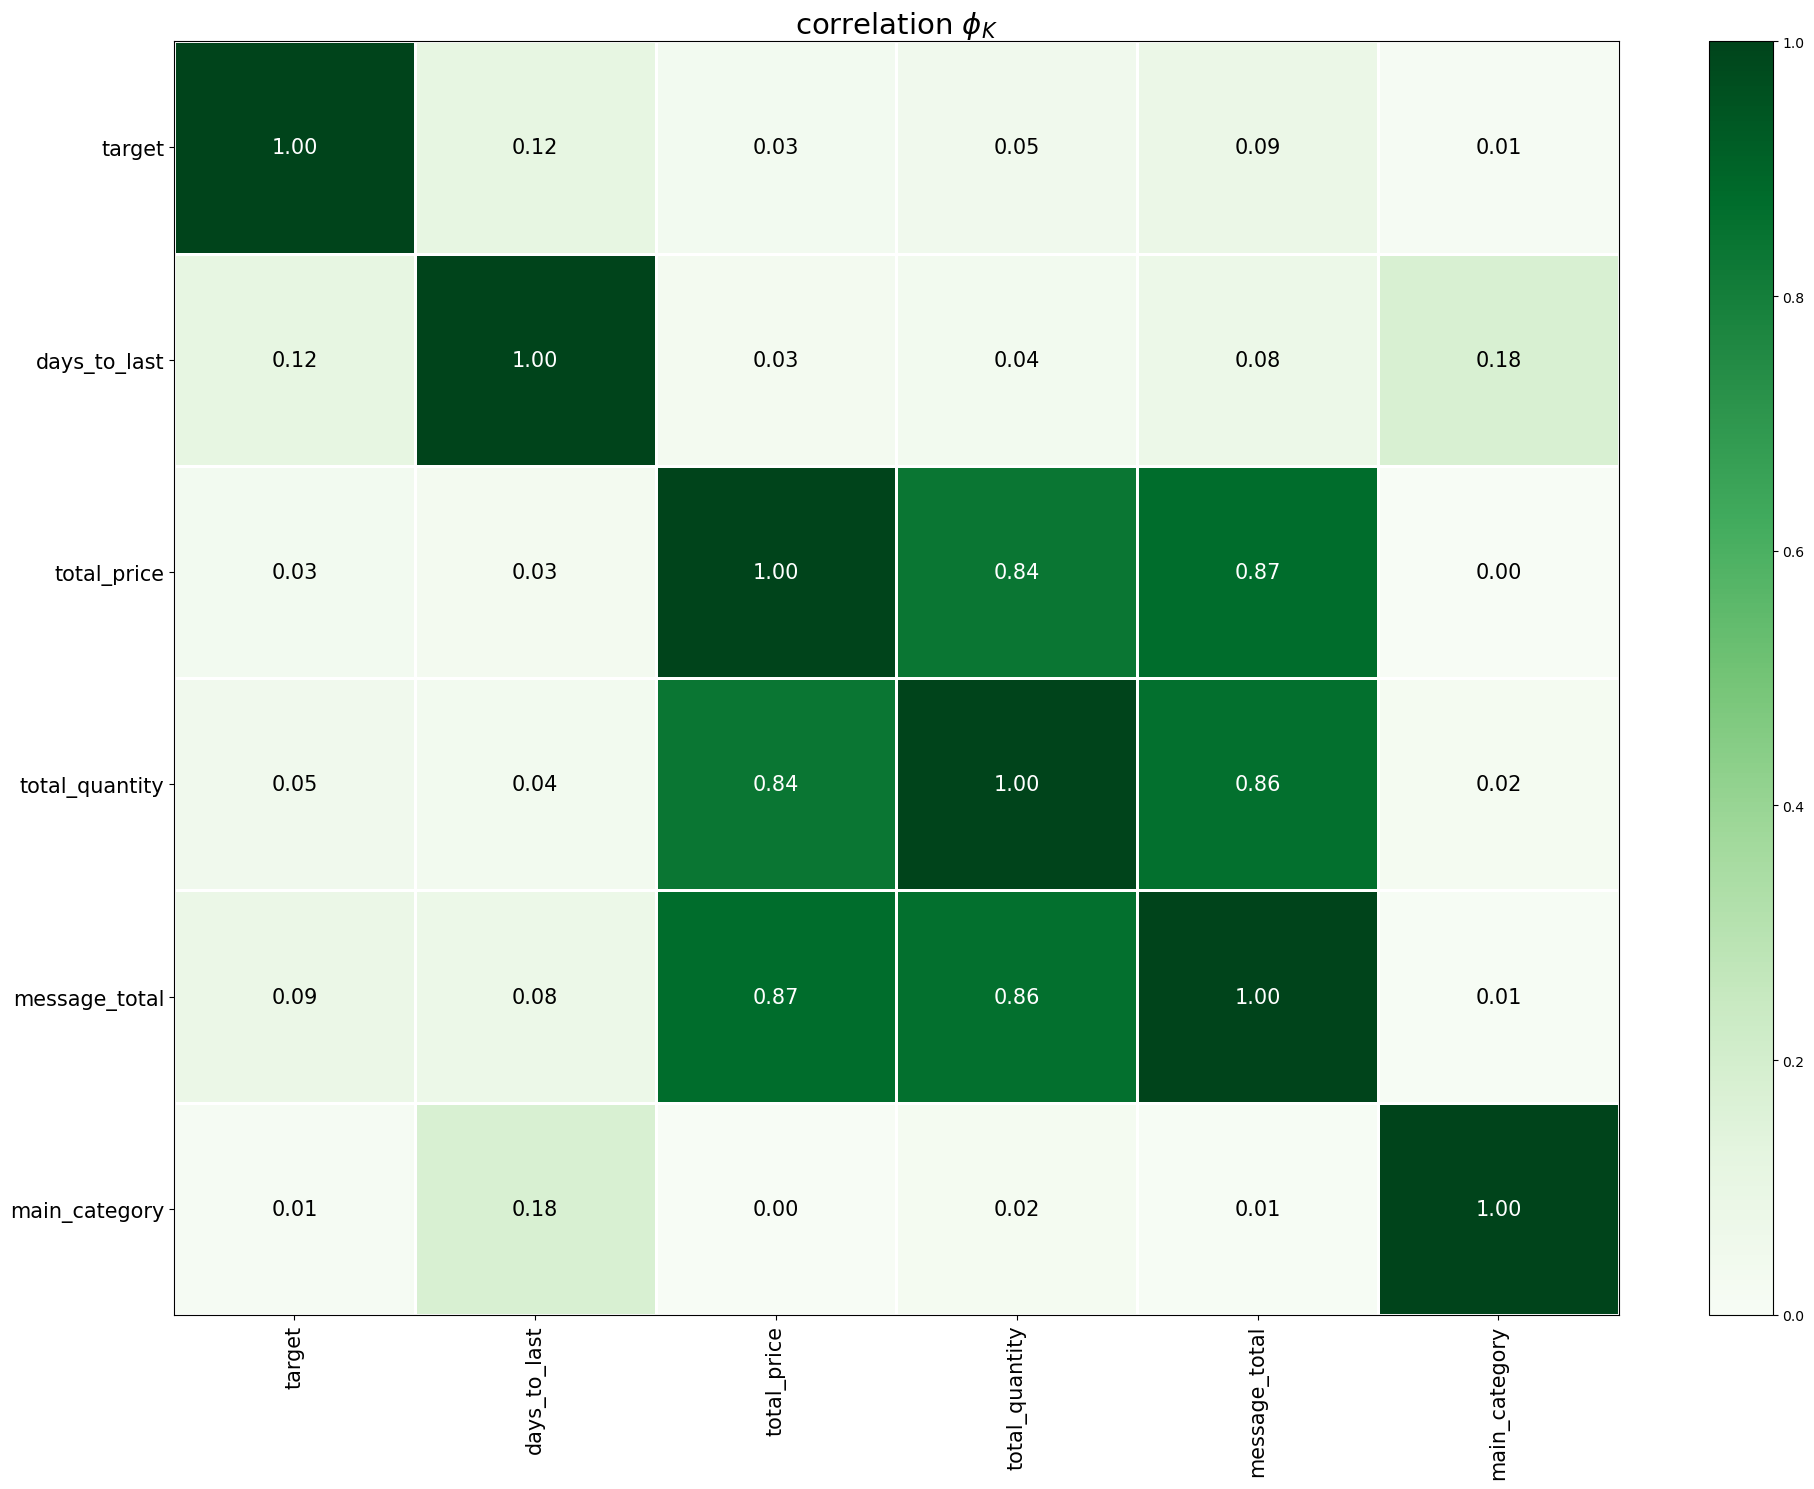

In [54]:
interval_cols =purch_pivot.select_dtypes(include='number').columns.tolist()[1:]
phik_overview = phik_matrix(purch_pivot.drop(['client_id', 'date_count'], axis=1), interval_cols=interval_cols) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

## Обучение моделей

In [55]:
X = purch_pivot.drop(['target', 'client_id', 'date_count'], axis=1)
y = purch_pivot['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [56]:
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

In [57]:
cat_cols

['main_category']

In [58]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('cat', ohe_pipe, cat_cols),
     ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [59]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat': [ohe_pipe, ord_pipe, 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_split': range(2,7),
        'models__min_samples_leaf': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat': [ohe_pipe, ord_pipe, 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__penalty': ['l1', 'l2', 'elasticnet', 'None'],
        'models__C': np.linspace(0, 20, 20),
        'models__max_iter': [100, 200, 500, 1000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__cat': [ohe_pipe, ord_pipe, 'passthrough']
     }
] 

In [60]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
)

In [61]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['main_category']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['message_total',
                                                                          'total_qu...
                                                                               sparse_output=False))]),
                                                Pipeline(steps=[('simpleImputer_before_ord',
                                                                 SimpleImputer(strategy='most_frequent')),
                                                                ('ord',
                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                unknown_value=nan)),
                                                                ('simpleImputer_after_ord',
                                                                 SimpleImputer(strategy='most_frequent'))]),
                                                'passthrough'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [62]:
grid.best_params_

{'models': LogisticRegression(C=7.368421052631579, class_weight='balanced',
                    random_state=42),
 'models__C': 7.368421052631579,
 'models__max_iter': 100,
 'models__penalty': 'l2',
 'preprocessor__cat': 'passthrough',
 'preprocessor__num': StandardScaler()}

In [63]:
print(f'Значение метрики roc_auc на тренировочной выборке лучшей модели равняется {grid.best_score_:.2f}')

Значение метрики roc_auc на тренировочной выборке лучшей модели равняется 0.69


In [64]:
print(f'Значение метрики roc_auc на тестовой выборке лучшей модели равняется {roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1]):.2f}')

Значение метрики roc_auc на тестовой выборке лучшей модели равняется 0.70


Оценим значимость признаков

In [65]:
print(grid.best_estimator_['models'].coef_)

[[-1.75899187e-05  3.64626314e-01  1.43828575e-01 -6.67126460e-02
  -4.25688875e-01]]


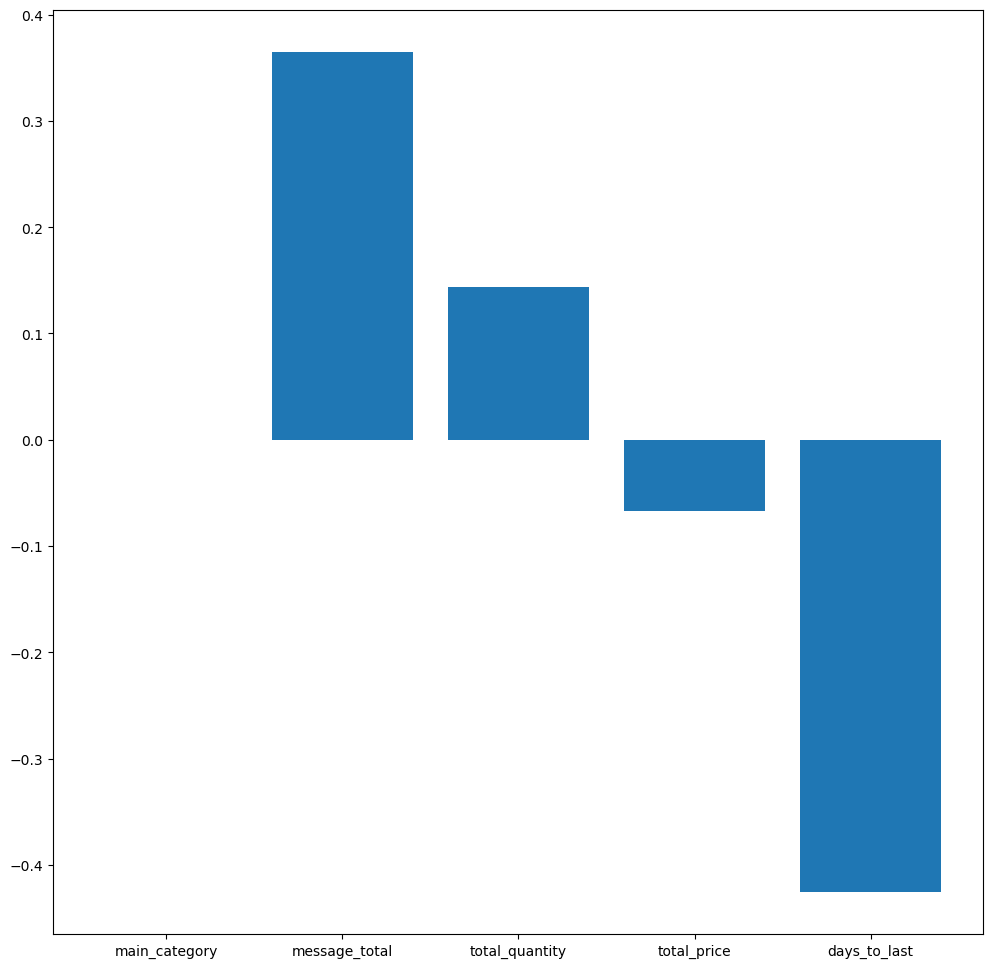

In [66]:
features = X_train.columns
importance =grid.best_estimator_['models'].coef_[0]
plt.figure(figsize=(12,12))
plt.bar(features, importance)
plt.show()


Наиболее важные признаки: общее количество сообщений пользователю (чем больше, тем выше шанс покупки) и время прошедшее с последней покупки (чем больше времени прошло, тем меньше шанс покуки).

## Выводы

На основании представленных данных был постоен сводный датасет по всем клиентам из целевого датасета со следующими признаками:
- основная категория закупок пользователя,
- общее число сообщений пользователю,
- общее количество единиц товара купленных пользователем,
- общая сумма покупок пользователя, 
- время с последней покупки пользователя.

Лучшая модель, предсказывающая поведение пользователя, - модель логистической регрессии с гиперпараметрами 'models__C': 7.368421052631579, 'models__penalty': 'l2'. Значение метрики ROC_AUC лучшей модели на тестовых данных равно 0.7.
Наиболее важные признаки - общее число сообщений пользователю и время с последней покупки пользователя.
